In [2]:
from SafeTransformer import SafeTransformer

In [4]:
from sklearn.datasets import load_boston

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

In [6]:
import pandas as pd

In [7]:
surrogate_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    loss='huber')

In [19]:
surrogate_model = surrogate_model.fit(X_train, y_train)



In [8]:
data = load_boston()

In [9]:
X = data['data']

In [10]:
names = data.feature_names
X = pd.DataFrame(X, columns=names)

In [11]:
y = data['target']

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pens = np.linspace(0.01, 10, 25)
best_score = float('Inf')
best_pen = 0
X_train, X_test, y_train, y_test = train_test_split(X, y)
linear_model_standard = LinearRegression()
linear_model_standard = linear_model_standard.fit(X_train, y_train)
standard_predictions = linear_model_standard.predict(X_test)
        

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [30]:
errors = []
surrogate_model = surrogate_model.fit(X_train, y_train)
for pen in pens:
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)

    safe_transformer = safe_transformer.fit(pd.DataFrame(X_train))

    X_train_transformed = safe_transformer.transform(X_train)

    X_test_transformed = safe_transformer.transform(X_test)

    linear_model_transformed = LinearRegression()

    linear_model_transformed = linear_model_transformed.fit(X_train_transformed, y_train)

    surrogate_predictions = linear_model_transformed.predict(X_test_transformed)
    error = mean_squared_error(y_test, surrogate_predictions)
    errors.append(error)
    print(mean_squared_error(y_test, standard_predictions), error)
    if error < best_score:
        best_score = error
        best_pen = pen

20.3011437693 37.8265462124
20.3011437693 12.8124476736
20.3011437693 12.3266105038
20.3011437693 12.6990574569
20.3011437693 12.8946139728
20.3011437693 12.8502168399
20.3011437693 14.711596996
20.3011437693 14.5118048177
20.3011437693 14.5118048177
20.3011437693 14.5485605447
20.3011437693 14.5105550014
20.3011437693 14.5272432764
20.3011437693 14.0947937571
20.3011437693 14.0947937571
20.3011437693 14.2347417039
20.3011437693 13.9290865907
20.3011437693 13.7043962815
20.3011437693 13.7043962815
20.3011437693 13.4663070881
20.3011437693 13.4549410315
20.3011437693 13.6722785211
20.3011437693 13.6722785211
20.3011437693 14.0998783348
20.3011437693 14.0998783348
20.3011437693 14.1433906638


In [32]:
gb_predictions = surrogate_model.predict(X_test)
print(mean_squared_error(y_test, gb_predictions))

9.47972914221


In [33]:
import matplotlib.pyplot as plt

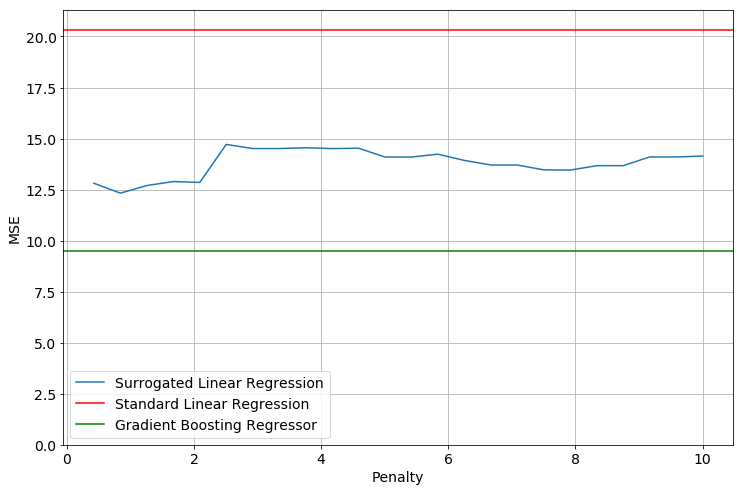

In [34]:
standard_error = mean_squared_error(y_test, standard_predictions)
xgb_error = mean_squared_error(y_test, gb_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[1:], errors[1:], label='Surrogated Linear Regression')
plt.xlabel('Penalty')
plt.ylabel('MSE')
plt.grid(True)
plt.axhline(standard_error, color='r', label='Standard Linear Regression')
plt.axhline(xgb_error, color='g', label='Gradient Boosting Regressor')
plt.ylim((0, max(max(errors[1:])+1, standard_error+1)))
plt.legend()
plt.show()

In [35]:
X_train_df = pd.DataFrame(X_train)

In [36]:
X_test_df = pd.DataFrame(X_test)

In [37]:

#safe_transformer = safe_transformer.fit(X_train_df, surrogate_model, penalty = 0.84)

X_train_transformed = safe_transformer.fit_transform(X_train_df)

In [38]:
from sklearn.pipeline import Pipeline


In [ ]:
from sklearn.pipeline import Pipeline
from SafeTransformer import SafeTransformer

In [39]:
linear_model = LinearRegression()
safe_transformer = SafeTransformer(surrogate_model, penalty = 0.84)
pipe = Pipeline(steps=[('safe', safe_transformer), ('linear', linear_model)])
pipe = pipe.fit(X_train_df, y_train)
predictions = pipe.predict(X_test)

In [40]:
mean_squared_error(y_test, predictions)

12.326610503804211

In [41]:
linear_model_standard = LinearRegression()
linear_model_standard = linear_model_standard.fit(X_train, y_train)
standard_predictions = linear_model_standard.predict(X_test)

In [42]:
mean_squared_error(y_test, standard_predictions)

20.301143769321314